In [1]:
import pymongo
import pandas as pd
from pymongo import MongoClient


import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

## For analysis, we'll begin by importing all of our data from MongoDb

In [2]:
client = MongoClient()
db_nba= client.nba


collection_p = db_nba.player_stats
df_nba = pd.DataFrame(list(collection_p.find()))

collection_t = db_nba.team_stats
df_team = pd.DataFrame(list(collection_t.find()))

collection_r = db_nba.team_rosters
df_r = pd.DataFrame(list(collection_r.find()))

Let's take a high-level look at our player stats dataframe.

In [3]:
df_nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8712 entries, 0 to 8711
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                8712 non-null   object 
 1   Player_ID          8712 non-null   int64  
 2   GROUP_VALUE        8712 non-null   object 
 3   TEAM_ID            8712 non-null   int64  
 4   TEAM_ABBREVIATION  8712 non-null   object 
 5   GP                 8712 non-null   int64  
 6   W                  8712 non-null   int64  
 7   L                  8712 non-null   int64  
 8   FGM                8712 non-null   int64  
 9   FGA                8712 non-null   int64  
 10  FG_PCT             8712 non-null   float64
 11  FG3M               8712 non-null   int64  
 12  FG3A               8712 non-null   int64  
 13  FG3_PCT            8712 non-null   float64
 14  FTM                8712 non-null   int64  
 15  FTA                8712 non-null   int64  
 16  FT_PCT             8712 

## Looks like we can clean this up a bit. 

First, we don't need the '_id' column, as this is a Mongo convention to identify individual entries.
Second, we can rename the 'GROUP_VALUE' column to 'season', based on our knowledge of that column in builder the scrapers.
Lastly, let's convert all column names to lowercase for ease of indexing.

In [4]:
df_nba.drop(columns=['_id'], inplace = True)
df_nba.rename(columns={'GROUP_VALUE':'season'}, inplace = True)

In [5]:
d_lower = dict()
for i in df_nba.columns:
    d_lower[i] = i.lower()

df_nba.rename(columns=d_lower, inplace = True)
df_nba.columns

Index(['player_id', 'season', 'team_id', 'team_abbreviation', 'gp', 'w', 'l',
       'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka',
       'pf', 'pfd', 'pts', 'plus_minus'],
      dtype='object')

In [6]:
# Check scraper progress

max_id = np.max(df_nba['player_id'])

In [7]:
df_nba.loc[df_nba['player_id']==max_id]

,player_id,season,team_id,team_abbreviation,gp,w,l,fgm,fga,fg_pct,...,reb,ast,tov,stl,blk,blka,pf,pfd,pts,plus_minus
8704,201576,2013-14,1610612743,DEN,43,15,28,68,176,0.386,...,122,32,39,26,19,12,64,50,206,-114
8705,201576,2012-13,1610612743,DEN,39,29,10,56,114,0.491,...,95,12,37,19,21,14,41,29,143,4
8706,201576,2011-12,1610612750,MIN,34,10,24,94,200,0.470,...,123,19,40,13,35,18,56,62,252,-39
8707,201576,2010-11,-1,TOT,40,11,29,123,264,0.466,...,160,33,53,22,24,16,62,73,305,-140
8708,201576,2010-11,1610612750,MIN,23,4,19,109,219,0.498,...,120,26,43,18,16,15,47,64,270,-113
8709,201576,2010-11,1610612752,NYK,17,7,10,14,45,0.311,...,40,7,10,4,8,1,15,9,35,-27
8710,201576,2009-10,1610612744,GSW,33,11,22,137,309,0.443,...,215,42,49,28,51,28,92,100,384,-74
8711,201576,2008-09,1610612744,GSW,63,21,42,199,431,0.462,...,363,49,80,42,74,35,141,118,499,-94


The last bit of preliminary cleaning will be to get rid of all entries for the 2019-20 season, as the season was stalled, so we won't have any target values. We can do this via indexing.

In [8]:
df_nba.drop(df_nba[df_nba['season'] == '2019-20'].index , inplace=True)

In [9]:
max_pm = np.max(df_nba['plus_minus'])
df_nba.loc[df_nba['plus_minus']== max_pm]

,player_id,season,team_id,team_abbreviation,gp,w,l,fgm,fga,fg_pct,...,reb,ast,tov,stl,blk,blka,pf,pfd,pts,plus_minus
5807,2544,2008-09,1610612739,CLE,81,66,15,789,1613,0.489,...,613,587,241,137,93,59,139,583,2304,872


# We first want to investigate the predictivity of regular season wins and playoff seeding based on a team roster's individual efficiency ratings from the prior year. 

There are a handful of efficiency metrics that are worth invesitgating here:

Martin Manley's Efficiency ('EFF') = ((Points + Rebounds + Assists + Steals + Blocks) - (Missed Field Goals + Missed Free Throws + Turnovers))/ Games Played

European Performance Index Rating ('PIR') = ((Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) - (Missed Field Goals + Missed Free Throws + Turnovers + Shots Rejected + Fouls Committed))/ Games Played

Plus-Minus Avg('+/-') = Seasonal plus-minus / Games Played : This describes the point differential for each game with a player on the floor without keeping track of more specific individual metrics. I.e., how does the score spread change when a player is in the game?

Note: We will not be considering John Hollinger's Player Efficiency Rating ('PER'): It is the most frequently used alternative, however PER is derived by a very complex calculation designed to compensate for different teams' varying style of play, among other factors, and PER scores do not differ markedly from EFF scores.

This study is more so interested in an individual player's efficiency being predictive of team success, regardless of coaching and playing styles. Furthermore, looking at these raw statistics will help inform to what extent a coach should seek to opitimize all individual player efficiencies, or spend a majority of their time tending to star players, or perhaps optimizing other metrics via playing style.

# Let's calculate EFF, PIR, and +/- for each player on a per season basis. Then we'll aggregate team rosters on a yearly basis, to eventually offset one season's stats to be fit to the following season's results.

In [10]:
df_nba.columns

Index(['player_id', 'season', 'team_id', 'team_abbreviation', 'gp', 'w', 'l',
       'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka',
       'pf', 'pfd', 'pts', 'plus_minus'],
      dtype='object')

In [11]:
"""EFF = ((Points + Rebounds + Assists + Steals + Blocks) - Missed Field Goals - Missed Free Throws - Turnovers))/ Games Played"""

df_nba['eff'] = ((df_nba['pts']+ df_nba['reb']+df_nba['ast']+df_nba['stl']+df_nba['blk']) \
                 - (df_nba['fga']-df_nba['fgm']) \
                 - (df_nba['fta']-df_nba['ftm']) \
                 - df_nba['tov']) / df_nba['gp']


"""PIR = ((Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) - Missed Field Goals - Missed Free Throws - Turnovers - Shots Rejected - Fouls Committed))/ Games Played"""
df_nba['pir'] = ((df_nba['pts']+ df_nba['reb']+df_nba['ast']+df_nba['stl']+df_nba['blk']+df_nba['pfd']) \
                 - (df_nba['fga']-df_nba['fgm']) \
                 - (df_nba['fta']-df_nba['ftm']) \
                 - df_nba['tov'] \
                 - df_nba['blka'] \
                 - df_nba['pf']) / df_nba['gp']
df_nba['+/-'] = df_nba['plus_minus'] / df_nba['gp']

## Below are the results of our EFF and PIR calculations.

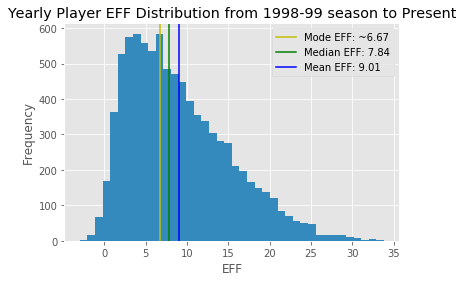

In [12]:
#Calculate all EFF averages and plot histogram to inform distribution

mean_eff = round(np.mean(df_nba['eff']),2)
median_eff = round(np.median(df_nba['eff']),2)

fig, ax = plt. subplots()

# ax.hist(df_nba['eff'], bins = 40)
ax.set_title('Yearly Player EFF Distribution from 1998-99 season to Present')

# Index to highest frequency bin
counts, bins = ax.hist(df_nba['eff'], bins = 40)[0],ax.hist(df_nba['eff'], bins = 40)[1]

idx_max = np.argmax(counts)
upper = bins[idx_max+1]
lower = bins[idx_max]
mode_eff = round(np.mean([upper,lower]),2)

ax.axvline(mode_eff, color = 'y', label = f'Mode EFF: ~{mode_eff}')
ax.axvline(median_eff, color = 'g', label = f'Median EFF: {median_eff}')
ax.axvline(mean_eff, color = 'b', label = f'Mean EFF: {mean_eff}')

ax.set_ylabel('Frequency')
ax.set_xlabel('EFF')
ax.legend()


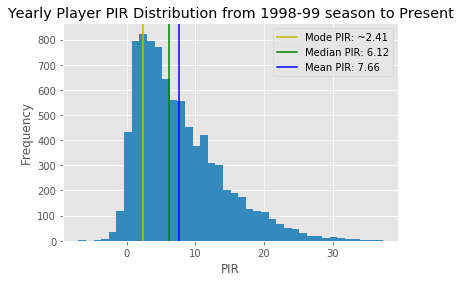

In [13]:
#Calculate all PIR averages and plot histogram to inform distribution

mean_pir = round(np.mean(df_nba['pir']), 2)
median_pir = round(np.median(df_nba['pir']),2)

fig, ax = plt. subplots()

# ax.hist(df_nba['pir'], bins = 40)
ax.set_title('Yearly Player PIR Distribution from 1998-99 season to Present')

# Index to highest frequency bin
counts, bins = ax.hist(df_nba['pir'], bins = 40)[0],ax.hist(df_nba['pir'], bins = 40)[1]

idx_max = np.argmax(counts)
upper = bins[idx_max+1]
lower = bins[idx_max]
mode_pir = round(np.mean([upper,lower]),2)

ax.axvline(mode_pir, color = 'y', label = f'Mode PIR: ~{mode_pir}')
ax.axvline(median_pir, color = 'g', label = f'Median PIR: {median_pir}')
ax.axvline(mean_pir, color = 'b', label = f'Mean PIR: {mean_pir}')

ax.set_ylabel('Frequency')
ax.set_xlabel('PIR')
ax.legend()


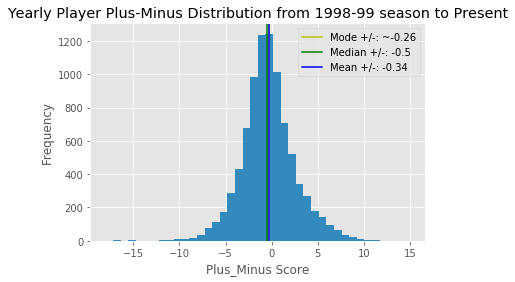

In [14]:
#Calculate all +/- averages and plot histogram to inform distribution

mean_pm = round(np.mean(df_nba['+/-']),2)
median_pm = round(np.median(df_nba['+/-']),2)

fig, ax = plt. subplots()

# ax.hist(df_nba['eff'], bins = 40)
ax.set_title('Yearly Player Plus-Minus Distribution from 1998-99 season to Present')

# Index to highest frequency bin
counts, bins = ax.hist(df_nba['+/-'], bins = 40)[0],ax.hist(df_nba['+/-'], bins = 40)[1]

idx_max = np.argmax(counts)
upper = bins[idx_max+1]
lower = bins[idx_max]
mode_pm = round(np.mean([upper,lower]),2)

ax.axvline(mode_pm, color = 'y', label = f'Mode +/-: ~{mode_pm}')
ax.axvline(median_pm, color = 'g', label = f'Median +/-: {median_pm}')
ax.axvline(mean_pm, color = 'b', label = f'Mean +/-: {mean_pm}')

ax.set_ylabel('Frequency')
ax.set_xlabel('Plus_Minus Score')
ax.legend()

## Now let's group the player data by player_id and season, so that we can pull the ['eff'] values from a prior year, and use those as features for a team based on roster. 

First, we'll group the dataframe by players and season. We do this instead of grouping by teams and season, to allow for us to account for roster changes season over season.

We can then reference player_id values for the target season to ensure we're selecting the right features (i.e, player statistics from the previous year, regardless of team affiliation). 

In [15]:
# First we'll group just by player so we can check if a particular season is relevant to them. 

df_by_player = df_nba.groupby(['player_id'])


In [16]:
3 in df_nba['player_id'].to_numpy()

True

In [17]:
# Here we group by both player and season so that we can pull particular efficiency scores per player per year.

df_by_p_s = df_nba.groupby(['player_id','season'])

In [18]:
df_by_p_s.get_group((3,'1998-99'))

,player_id,season,team_id,team_abbreviation,gp,w,l,fgm,fga,fg_pct,...,stl,blk,blka,pf,pfd,pts,plus_minus,eff,pir,+/-
4,3,1998-99,1610612737,ATL,50,31,19,151,359,0.421,...,57,16,25,143,2,489,205,11.56,8.24,4.1


## Now, we can iterate through team rosters by season to pull the prior year's efficiency metrics per player. 

Investigate roster dataframe to determine how to properly pull ['eff'] from player dataframe.

In [19]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _id     630 non-null    object
 1   team    630 non-null    int64 
 2   season  630 non-null    object
 3   roster  630 non-null    object
dtypes: int64(1), object(3)
memory usage: 19.8+ KB


Again, we can drop the '_id' column, as this is just a mongo convention

In [20]:
df_r.drop(columns = ['_id'], inplace = True)

In [21]:
df_r.head()

,team,season,roster
0,1610612737,1998-99,"[673, 1533, 1544, 87, 1516, 3, 1852, 111, 770,..."
1,1610612738,1998-99,"[692, 952, 1477, 1800, 344, 368, 35, 65, 72, 1..."
2,1610612739,1998-99,"[692, 226, 682, 1510, 1538, 916, 198, 1507, 18..."
3,1610612740,1998-99,[]
4,1610612741,1998-99,"[457, 82, 699, 1869, 1736, 1757, 54, 1522, 160..."


## It will be worthwhile to examine the sizes of the rosters so that we can encompass to see if there's any relationship between that and a team's success. 

In [22]:
df_r['len_roster'] = [len(r) for r in df_r['roster'].to_numpy()]

In [23]:
max_r = df_r['len_roster'][np.argmax(df_r['len_roster'])]
df_r.loc[df_r['len_roster']==max_r]

,team,season,roster,len_roster
536,1610612763,2015-16,"[1627293, 2757, 201148, 1627362, 203955, 2365,...",28
626,1610612763,2018-19,"[1626150, 202340, 203998, 101139, 202718, 2034...",28


It's unlikely that the efficiency scores for all 28 people on this particular roster will be noteworthy features, but this is worth noting now to see if there is any relationship between roster churn and success.

In [24]:
df_nba.loc[(df_nba['team_id']==1610612763) & (df_nba['season']=='2015-16')]

,player_id,season,team_id,team_abbreviation,gp,w,l,fgm,fga,fg_pct,...,stl,blk,blka,pf,pfd,pts,plus_minus,eff,pir,+/-
3143,1713,2015-16,1610612763,MEM,60,33,27,133,343,0.388,...,38,16,14,101,76,395,-35,6.533333,5.883333,-0.583333
4946,2216,2015-16,1610612763,MEM,68,37,31,431,907,0.475,...,43,13,72,146,190,1040,-11,16.794118,16.382353,-0.161765
5248,2365,2015-16,1610612763,MEM,20,7,13,34,62,0.548,...,14,10,5,25,31,92,-53,8.450000,8.500000,-2.650000
5650,2440,2015-16,1610612763,MEM,76,38,38,264,693,0.381,...,78,57,35,234,103,758,-210,11.828947,9.644737,-2.763158
6685,2754,2015-16,1610612763,MEM,64,34,30,215,469,0.458,...,110,18,59,175,105,535,-91,10.140625,8.125000,-1.421875
6728,2757,2015-16,1610612763,MEM,8,3,5,20,46,0.435,...,3,1,6,11,12,47,-18,6.125000,5.500000,-2.250000
7811,200770,2015-16,1610612763,MEM,12,2,10,42,100,0.420,...,15,2,7,22,17,110,-64,9.416667,8.416667,-5.333333
7939,200797,2015-16,1610612763,MEM,32,16,16,45,72,0.625,...,6,20,12,58,47,116,-130,5.468750,4.750000,-4.062500
8090,201144,2015-16,1610612763,MEM,56,33,23,294,696,0.422,...,67,16,33,100,184,857,66,16.464286,17.375000,1.178571
8104,201145,2015-16,1610612763,MEM,53,31,22,240,557,0.431,...,40,19,42,102,134,646,-33,11.830189,11.641509,-0.622642


## For sake of indexing, we need to get all unique team IDs and seasons into two separate arrays.

We'll then group the roster dataframe by team and season, and use Pandas' get_group() method to pull the roster for a given season. We'll then iterate through the roster to select player efficiency scores from the prior year in the df_by_player dataframe via player_id and season. 

In [25]:
teams = np.unique(df_team['TeamID'])
seasons = np.unique(df_nba['season'])

teams,seasons

(array([1610612737, 1610612738, 1610612739, 1610612740, 1610612741,
        1610612742, 1610612743, 1610612744, 1610612745, 1610612746,
        1610612747, 1610612748, 1610612749, 1610612750, 1610612751,
        1610612752, 1610612753, 1610612754, 1610612755, 1610612756,
        1610612757, 1610612758, 1610612759, 1610612760, 1610612761,
        1610612762, 1610612763, 1610612764, 1610612765, 1610612766]),
 array(['1997-98', '1998-99', '1999-00', '2000-01', '2001-02', '2002-03',
        '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09',
        '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15',
        '2015-16', '2016-17', '2017-18', '2018-19'], dtype=object))

## Group roster dataframe by team_id and season

In [26]:
df_r = df_r.groupby(['team','season'])


In [27]:
roster = df_r.get_group((1610612737,'1998-99'))['roster']
for r in roster:
    print(r)

[673, 1533, 1544, 87, 1516, 3, 1852, 111, 770, 302, 1728, 1742, 120, 895]


Because the line above just converted the variable df_r to a Pandas' groupby object, we'll need to call get_group() going forward to view and pull data.

Let's use our 'teams' and 'seasons' lists from above to do just that.

We'll also want to account for games played, as this will influence the magnitufe of an individuals' efficiency score contributing to wins. We'll create an adjusted efficiency score to do this by dividing by games played. This should capture the extent to which a particular player contributed to a team's success. 

In [61]:
#Generalized function for generating a feature matrix
def gen_X(teams,seasons,stat):  
    
    """
    PARAMETERS:
    
    teams - list of team IDs
    season - list of seasons
    stat - string of column title in player dataframe for statistic of interest
    
    RETURNS:
    
    Feature matrix to be used for predicting wins and playoff rankings of teams
    """
    
    X = []

    # Index into each team
    for t in teams:

        # Index into each season
        for idx, s in enumerate(seasons):

            # We only care about prior year stats, and we can't index into the prior year if idx is 0
            if idx > 0:

                # create a row for our features array
                row = [int(t),s]

                #accumulator for efficiency scores
                lst_stat = []

                # select roster and loop through player_ids to pull efficiency scores from prior year in df_by_player
                roster = list(df_r.get_group((t.item(),s))['roster'])

                for p in roster[0]:

                    #for sake of testing the code, make sure a player_id is in our dataset
                    if p in df_nba['player_id'].to_numpy():

                        #Check a given season is relevant to a player
                        if seasons[idx-1] in df_by_player.get_group(p)['season'].to_numpy():

                            #select a player's efficiency score from the prior season 
                            #because we want to predict outcomes of current year
                            stat_ = df_by_p_s.get_group((p,seasons[idx-1]))[stat].to_numpy()[0]
                            lst_stat.append(int(stat_))

            #Create accumulator array to account for differing sizes in rosters
                final_stat = np.zeros(max_r)
                for idx,stat_ in enumerate(lst_stat):
                    final_stat[idx] = int(stat_)

            # sort efficiency scores in descending order such that we are comparing players 
            # of equal team hierarchical rank within feature columns
                final_stat = np.sort(final_stat)[::-1]

                row = np.concatenate((row,final_stat), axis = None)

                X.append(row)
    
    # Generate dataframe and properly name columns
    df_X = pd.DataFrame(X)
    
    col_names = dict()

    for idx,col in enumerate(df_X.columns):
        if idx>1:
            col_names[idx] = f'player_rank{idx-1}'
        elif idx == 0:
            col_names[idx] = 'team_id'
        else:
            col_names[idx] = 'season'
    
    df_X.rename(columns = col_names, inplace=True)
    
    return df_X

In [63]:
df_X = gen_X(teams,seasons,'eff')

In [30]:
df_X

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1610612737,1998-99,21.0,18.0,16.0,14.0,13.0,11.0,7.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1610612737,1999-00,20.0,12.0,11.0,10.0,10.0,9.0,8.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1610612737,2000-01,23.0,14.0,13.0,13.0,13.0,9.0,7.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1610612737,2001-02,22.0,18.0,16.0,11.0,9.0,9.0,7.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1610612737,2002-03,22.0,18.0,18.0,12.0,11.0,10.0,7.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,1610612766,2014-15,24.0,11.0,9.0,4.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
626,1610612766,2015-16,18.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
627,1610612766,2016-17,15.0,9.0,8.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
628,1610612766,2017-18,21.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's rename the columns for readability in our feature matrix. 

## We have our features matrix (X) above. Now onto our targets. 

In [33]:
df_team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   _id               624 non-null    object
 1   SeasonID          624 non-null    object
 2   TeamID            624 non-null    int64 
 3   TeamCity          624 non-null    object
 4   TeamName          624 non-null    object
 5   Conference        624 non-null    object
 6   ConferenceRecord  624 non-null    object
 7   PlayoffRank       624 non-null    int64 
 8   ClinchIndicator   620 non-null    object
 9   Division          624 non-null    object
 10  DivisionRecord    624 non-null    object
 11  DivisionRank      624 non-null    int64 
 12  WINS              624 non-null    int64 
 13  LOSSES            624 non-null    int64 
dtypes: int64(5), object(9)
memory usage: 68.4+ KB


This study is interested in just the wins and playoff berth per team per season, so let's pullout the pertinent columns.

In [34]:
df_team = df_team[['SeasonID','TeamID','PlayoffRank','WINS','LOSSES']]
df_team

,SeasonID,TeamID,PlayoffRank,ClinchIndicator,WINS,LOSSES
0,21998,1610612753,1,,33,17
1,21998,1610612762,1,,37,13
2,21998,1610612754,1,,33,17
3,21998,1610612759,1,,37,13
4,21998,1610612748,1,,33,17
...,...,...,...,...,...,...
619,22018,1610612740,13,- o,33,49
620,22018,1610612742,14,- o,33,49
621,22018,1610612739,14,- o,19,63
622,22018,1610612752,15,- o,17,65


## A few things worth noting:

-There are only 50 games played in the 1998 season, so we'll need to transform that data to estimate the 82 game win total so it's consistent with the rest of our data.

-We can actually drop the ClinchIndicator column, as a PlayoffRank value of 8 or above also indicates a playoff birth.

Let's take care of that below. 

In [35]:
df_team.drop(columns='ClinchIndicator',inplace = True)

In [36]:
df_team['w'] = ((df_team['WINS'] / (df_team['WINS']+df_team['LOSSES'])) * 82).round()

In [37]:
df_team.rename(columns = {'TeamID': 'team_id'}, inplace= True)

Now we'll drop the 'WINS' and 'LOSSES' columns as they're extraneous.

In [38]:
df_team.drop(columns = ['WINS','LOSSES'], inplace = True)

We should also update our SeasonID columns so that its formatting is the same as that of 'season' in our df_X.

In [39]:
season1 = np.unique(df_X['season'])
season2 = np.unique(df_team['SeasonID'])

d = dict()
for s1, s2 in zip(season1,season2):
    d[s2] = s1
    
d

{'21998': '1998-99',
 '21999': '1999-00',
 '22000': '2000-01',
 '22001': '2001-02',
 '22002': '2002-03',
 '22003': '2003-04',
 '22004': '2004-05',
 '22005': '2005-06',
 '22006': '2006-07',
 '22007': '2007-08',
 '22008': '2008-09',
 '22009': '2009-10',
 '22010': '2010-11',
 '22011': '2011-12',
 '22012': '2012-13',
 '22013': '2013-14',
 '22014': '2014-15',
 '22015': '2015-16',
 '22016': '2016-17',
 '22017': '2017-18',
 '22018': '2018-19'}

In [40]:
df_team['season'] = [d[s] for s in df_team['SeasonID']]

In [41]:
df_team.drop(columns = 'SeasonID', inplace = True)

In [42]:
df_team

,team_id,PlayoffRank,w,season
0,1610612753,1,54.0,1998-99
1,1610612762,1,61.0,1998-99
2,1610612754,1,54.0,1998-99
3,1610612759,1,61.0,1998-99
4,1610612748,1,54.0,1998-99
...,...,...,...,...
619,1610612740,13,33.0,2018-19
620,1610612742,14,33.0,2018-19
621,1610612739,14,19.0,2018-19
622,1610612752,15,17.0,2018-19


In [43]:
df_team.sort_values(by = ['team_id','season'], inplace=True)

In [44]:
df_team

,team_id,PlayoffRank,w,season
6,1610612737,4,51.0,1998-99
56,1610612737,14,28.0,1999-00
83,1610612737,13,25.0,2000-01
109,1610612737,12,33.0,2001-02
136,1610612737,11,35.0,2002-03
...,...,...,...,...
494,1610612766,11,33.0,2014-15
515,1610612766,6,48.0,2015-16
554,1610612766,11,36.0,2016-17
583,1610612766,10,36.0,2017-18


In [45]:
df_team.info(),df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 6 to 611
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   team_id      624 non-null    int64  
 1   PlayoffRank  624 non-null    int64  
 2   w            624 non-null    float64
 3   season       624 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 24.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   team_id        630 non-null    object
 1   season         630 non-null    object
 2   player_rank1   630 non-null    object
 3   player_rank2   630 non-null    object
 4   player_rank3   630 non-null    object
 5   player_rank4   630 non-null    object
 6   player_rank5   630 non-null    object
 7   player_rank6   630 non-null    object
 8   player_rank7   630 non-null    object
 9 

(None, None)

## Uh-oh, looks like our shapes are different. Let's investigate the shape discrepancy.

In [47]:
np.unique(df_X['team_id'], return_counts = True)

(array(['1610612737', '1610612738', '1610612739', '1610612740',
        '1610612741', '1610612742', '1610612743', '1610612744',
        '1610612745', '1610612746', '1610612747', '1610612748',
        '1610612749', '1610612750', '1610612751', '1610612752',
        '1610612753', '1610612754', '1610612755', '1610612756',
        '1610612757', '1610612758', '1610612759', '1610612760',
        '1610612761', '1610612762', '1610612763', '1610612764',
        '1610612765', '1610612766'], dtype=object),
 array([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]))

In [48]:
np.unique(df_team['team_id'], return_counts = True)

(array([1610612737, 1610612738, 1610612739, 1610612740, 1610612741,
        1610612742, 1610612743, 1610612744, 1610612745, 1610612746,
        1610612747, 1610612748, 1610612749, 1610612750, 1610612751,
        1610612752, 1610612753, 1610612754, 1610612755, 1610612756,
        1610612757, 1610612758, 1610612759, 1610612760, 1610612761,
        1610612762, 1610612763, 1610612764, 1610612765, 1610612766]),
 array([21, 21, 21, 17, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 19]))

## Team_id 1610612740 only appears 17 times, and team_id 1610612766 only appears 19 times.

Perhaps this has to do with a team becoming defunct or moving locations. Let's figure out which franchises belong to these team_id values

In [49]:
np.unique(df_nba.loc[df_nba['team_id']==1610612740]['team_abbreviation'], return_counts = True), df_team.loc[df_team['team_id']==1610612740]['season']

((array(['NOH', 'NOK', 'NOP'], dtype=object), array([132,  34,  17])),
 124    2002-03
 153    2003-04
 202    2004-05
 223    2005-06
 253    2006-07
 266    2007-08
 307    2008-09
 345    2009-10
 366    2010-11
 412    2011-12
 440    2012-13
 466    2013-14
 489    2014-15
 527    2015-16
 553    2016-17
 575    2017-18
 619    2018-19
 Name: season, dtype: object)

In [50]:
np.unique(df_nba.loc[df_nba['team_id']==1610612766]['team_abbreviation'], return_counts = True), df_team.loc[df_team['team_id']==1610612766]['season']

((array(['CHA', 'CHH'], dtype=object), array([158,  73])),
 17     1998-99
 35     1999-00
 68     2000-01
 93     2001-02
 201    2004-05
 229    2005-06
 255    2006-07
 286    2007-08
 312    2008-09
 336    2009-10
 372    2010-11
 413    2011-12
 441    2012-13
 456    2013-14
 494    2014-15
 515    2015-16
 554    2016-17
 583    2017-18
 611    2018-19
 Name: season, dtype: object)

As suspected, both of the above franchises have undergone relocations in the most recent 20 years.

For New Orleans, we're missing the following seasons' data: 1998-99,1999-2000, 2000-01, 2001-02. 
For Charlotte, we're missing: 2002-03,2003-04

So, let's ensure that we're only pairing feature rows with records that actually have wins and playoff rank data. We can do this by dropping superfluous rows in the df_X

In [51]:
# store wins and playoff ranks pertinent to each season by team as targets.

y_w = []
y_pr = []
for t,s in zip(df_X['team_id'],df_X['season']):
    if s not in df_team.loc[df_team['team_id']==int(t)]['season'].to_numpy():
        w = None
        y_w.append(w)
        
        pr = None
        y_pr.append(pr)
    else:
        w = df_team.loc[(df_team['team_id']==int(t)) & (df_team['season'] == s)]['w'].to_numpy()[0]
        y_w.append(w)
        
        pr = df_team.loc[(df_team['team_id']==int(t)) & (df_team['season'] == s)]['PlayoffRank'].to_numpy()[0]
        y_pr.append(pr)
        
        
y_w = np.array(y_w)
y_pr = np.array(y_pr)

y_w.shape,y_pr.shape

((630,), (630,))

Looks like we're in business. Now that our target values are properly shaped, we can append get to work with modeling. Note that the y_w and y_pr vectors are already properyly ordered becasue of our iterative approach through the df_X['team_id'] and df_X['season'] columns.

In [52]:
# Compile into df_X for viewability

df_X['w'] = np.array(y_w)
df_X['pr'] = np.array(y_pr)

# re-establish the feature matrix

X = df_X.drop(columns = ['season','team_id'])


In [53]:
X = X.astype('float')
X.dropna(inplace=True)

In [54]:
X.shape

(624, 30)

In [55]:
y_w = X['w']
y_pr = X['pr']

y_w.shape,y_pr.shape

((624,), (624,))

## Let's try a 'Stupid Model' fit, just plugging in our values as is and seeing what we get.

## We'll look at individual EFF, PIR, and +/- scores

Because non of our data is categorical, and we can't ensure a linear relationship between our features and targets, a GradientBoost Regressor feels appropriate for both our playoff seed ranking and regular season wins predictions.

In [56]:
import sklearn

In [57]:
from sklearn.ensemble import GradientBoostingRegressor

In [58]:
gb = GradientBoostingRegressor()

In [59]:
gb.fit(X.drop(columns=['w','pr']),y_w)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [60]:
gb.score(X.drop(columns=['w','pr']),y_w)

0.5676583608358883